# Demographic Analysis

## Datasets

## Dataset and documentation: 
### Decennial Census
https://api.census.gov/data/2020/dec/pl.html
https://www.youtube.com/watch?v=vv4MZgqgHe8
### ACS Survey (Age)

In [250]:
RACE_POP_COUNT = 'RacePopCount.json'
ETHNIC_COUNT = 'EthnicPopCount.json'
AGE_COUNT = 'AgePopCount.json'
datasets_and_uris = {}
datasets_and_uris[RACE_POP_COUNT] = "http://api.census.gov/data/2020/dec/pl"
datasets_and_uris[ETHNIC_COUNT] = "http://api.census.gov/data/2020/dec/pl"

### Required Packages

In [251]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import altair as alt
from altair import datum
import json
import requests
import random
import time
import re
import requests
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


## Downloading Required Data

In [252]:
def createPredicatesRaceandEthnicityPopCount(tableId, var_cnt):
  '''
  create predicates for the census data API
  base_uri - This is the base uri for the census API
  tableId - table name, which we want to download
  var_cnt - Number of variables the table has 
  '''
  county = "*" #"099,163,125" - These are for Macomb, Wayne, Oakland specifically
  state= "26"
  estimate = []
  #moe = []
  for i in range(1, var_cnt+1):
    estimate.append(tableId + '_00' + str(i) + 'N')
    #moe.append(tableId + '_00' + str(i) + 'M')

  get_vars = estimate + ['NAME'] #+ moe
  predicates = {}
  predicates["get"] = ','.join(get_vars)
  predicates["for"] = "county:" + county
  predicates["in"] = "state:" + state
  
  return(predicates)

#def createPredicatesAge(county, token):
  #  '''
  #create predicates/headers for the CHAS data API
  #  county - County id for which we want to download the cost burden
  #  token - API token to access the CHAS API, CHN needs to register for CHAS API and get this token 
   # '''
    #predicates = {}
    #predicates['type'] = 3
    #predicates['stateId'] = 26
    ##predicates['entityId'] = county
    #auth_token_string = "Bearer "+ token
    #headers = {"Authorization": auth_token_string}
    #return(predicates, headers)


def download_data(base_uri,predicates, path, filename, headers=''):
    filepath = path + filename
    if os.path.isfile(filepath):
        print(filepath)
        print('file already exists, clearing and updating')
        open(filepath, 'w').close()
    #else:
        result = requests.get(base_uri, params=predicates, headers=headers) 
        if result.status_code == 200:
          with open(filepath, 'wb') as f:
              f.write(result.content)
        else:
          print('API returned Erro: ', result.status_code, '\n', 'Downloading of data failed.',  \
                'Please check the API')
    else: 
        result = requests.get(base_uri, params=predicates, headers=headers) 
        if result.status_code == 200:
          with open(filepath, 'wb') as f:
              f.write(result.content)
        else:
          print('API returned Erro: ', result.status_code, '\n', 'Downloading of data failed.',  \
                'Please check the API')

In [253]:
#Download Race Population Counts
tableId = 'P1'
var_cnt = 9
predicates = createPredicatesRaceandEthnicityPopCount(tableId, var_cnt)
ASSETS_PATH = ''
download_data(datasets_and_uris[RACE_POP_COUNT],predicates, ASSETS_PATH, RACE_POP_COUNT)

RacePopCount.json
file already exists, clearing and updating


In [254]:
#Download Ethnicity Counts Data
#Total Population Count; Hispanic or Latino of any race (Population Count); Non-Hispanic/Non-Latino (Population Count)
tableId = 'P2'
var_cnt = 3
predicates = createPredicatesRaceandEthnicityPopCount(tableId, var_cnt)
ASSETS_PATH = ''
download_data(datasets_and_uris[ETHNIC_COUNT],predicates, ASSETS_PATH, ETHNIC_COUNT)


EthnicPopCount.json
file already exists, clearing and updating


## Data Transformations - One Race Population Count and Two or More Races Total Population Count

In [255]:
race_pop_count_df = pd.read_json('RacePopCount.json')
race_pop_count_df.rename(columns={0:'total', 1:'one_tot',2:'one_wht', 3:'one_blk',
4:'one_ind', 5:'one_asn', 6:'one_pacific', 7:'one_other', 8:'two_more_total', 9:'NAME', 10:'state', 11:'county'}, inplace=True)
race_pop_count_df = race_pop_count_df.iloc[1:, :]
race_pop_count_df['NAME'] = race_pop_count_df['NAME'].str.split(',', expand=True).iloc[:, 0]
race_pop_count_df.drop(columns=['state', 'county'], inplace=True)

In [256]:
columns = list(race_pop_count_df.columns[:-1])
race_pop_count_df = pd.melt(race_pop_count_df, id_vars=['NAME'], value_vars=columns)
our_counties = ['Wayne County', 'Macomb County', 'Oakland County']
race_pop_count_df = race_pop_count_df[race_pop_count_df['NAME'].isin(our_counties)]
race_pop_count_df['value'] = race_pop_count_df['value'].map(lambda x: float(x))

In [257]:
#calculate percentages of population for each county
def dataframe_pct(dataframe, county_list):
    percentages = []
    for i in list(range(0,len(dataframe))):
        for county in county_list: 
            if dataframe.iloc[i,:]['NAME'] == county:
                total = dataframe[(dataframe['variable']=='total') & (dataframe['NAME']==county)]['value']
                percentages.append(round(dataframe.iloc[i,:]['value']/int(total),2))
    
    dataframe['pct'] = percentages
    
    return dataframe

In [258]:
race_pop_count_df = dataframe_pct(race_pop_count_df, our_counties)

## Data Transformations - Ethnic Population Count Hispanic and Non-Hispanic

In [259]:
ethnic_pop_count_df = pd.read_json('EthnicPopCount.json')

In [260]:
ethnic_pop_count_df.rename(columns={0:'total', 1:'tot_hisp_latino', 2:'tot_not_hisp', 3:'NAME',4:'state', 5:'county'}, inplace=True)
ethnic_pop_count_df = ethnic_pop_count_df.iloc[1:, :]
ethnic_pop_count_df['NAME'] = ethnic_pop_count_df['NAME'].str.split(',', expand=True).iloc[:, 0]
ethnic_pop_count_df.drop(columns=['state', 'county'], inplace=True)

In [261]:
ethnic_pop_count_df = pd.melt(ethnic_pop_count_df, id_vars=['NAME'], value_vars=['tot_hisp_latino', 'tot_not_hisp', 'total'])
our_counties = ['Wayne County', 'Macomb County', 'Oakland County']
ethnic_pop_count_df = ethnic_pop_count_df[ethnic_pop_count_df['NAME'].isin(our_counties)]
ethnic_pop_count_df['value'] = ethnic_pop_count_df['value'].map(lambda x: float(x))
ethnic_pop_count_df = ethnic_pop_count_df[ethnic_pop_count_df['NAME'].isin(our_counties)]
ethnic_pop_count_df['value'] = ethnic_pop_count_df['value'].map(lambda x: float(x))

In [262]:
#calculate percentages of population for each county
ethnic_pop_count_df = dataframe_pct(ethnic_pop_count_df, our_counties)

## Data Visualizations - Race Population Count

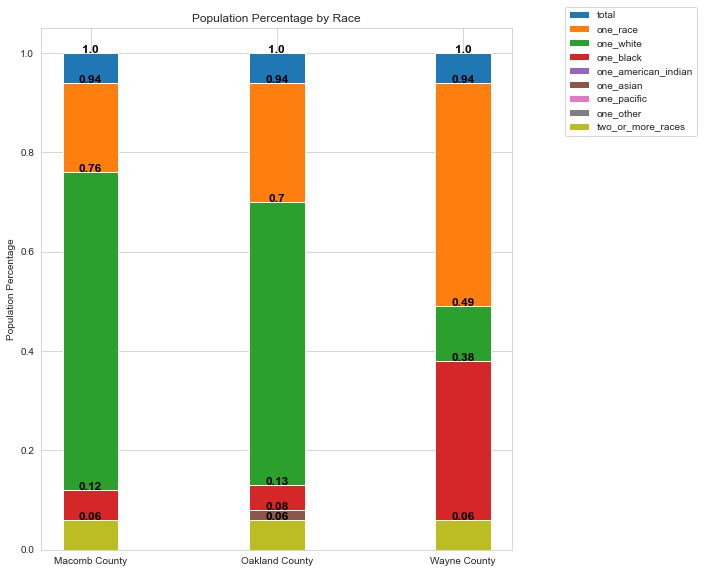

In [263]:
sns.set_style('whitegrid')
x = np.arange(len(race_pop_count_df['NAME'].unique()))
width = 0.3
labels = list(race_pop_count_df['NAME'].unique())
variables_pct = {}
for variable in race_pop_count_df['variable'].unique(): 
    variables_pct[variable] = race_pop_count_df.loc[race_pop_count_df['variable']==variable, 'pct']
    variables_pct[variable].apply(lambda x: float(x))

fig, ax = plt.subplots(figsize=(10,8))

total_pct = ax.bar(x , variables_pct['total'], width, label='total', align='center')
one_tot_pct = ax.bar(x , variables_pct['one_tot'], width, label='one_race', align='center')
one_wht_pct = ax.bar(x , variables_pct['one_wht'], width, label='one_white', align='center')
one_blk_pct = ax.bar(x , variables_pct['one_blk'], width, label='one_black', align='center')
one_ind_pct = ax.bar(x , variables_pct['one_ind'], width, label='one_american_indian', align='center')
one_asn_pct = ax.bar(x , variables_pct['one_asn'], width, label='one_asian', align='center')
one_pacific_pct = ax.bar(x , variables_pct['one_pacific'], width, label='one_pacific', align='center')
one_other_pct = ax.bar(x , variables_pct['one_other'], width, label='one_other', align='center')
two_more_total_pct = ax.bar(x , variables_pct['two_more_total'], width, label='two_or_more_races', align='center')
ax.set_ylabel('Population Percentage')
ax.set_xticks(x)
ax.set_title('Population Percentage by Race')
ax.ticklabel_format(useOffset=True, style='plain')
ax.legend(bbox_to_anchor=(1.1, 1.05))


y_offset = -10
for bar in ax.patches:
  if bar.get_height() >= 0.05:
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
    bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
    bar.get_height(),
    #bar.get_y() + y_offset,
      # This is actual value we'll show.
    bar.get_height(),
      # Center the labels and style them a bit.
    ha='center',
    #va = 'center',
    color='black',
    weight='bold',
    size=12)
# For each patch (basically each rectangle within the bar), add a label.
fig.canvas.draw()
fig.tight_layout()
plt.xticks(x, labels)
plt.xticks(ha='center')
plt.show()

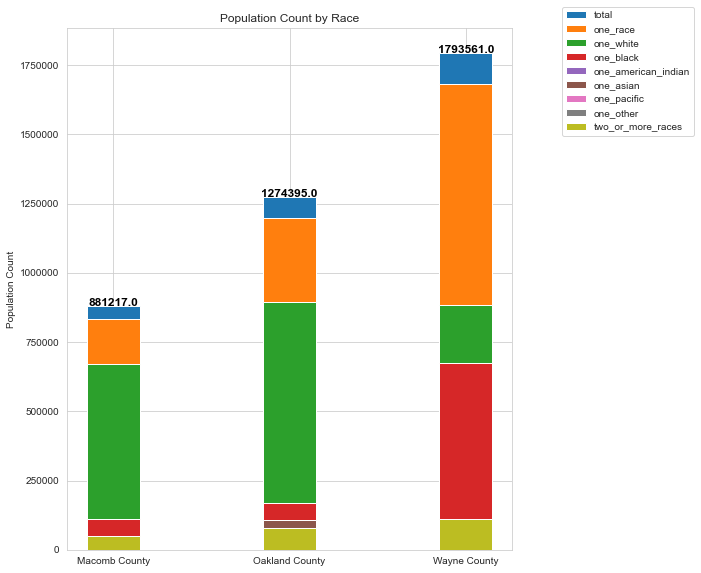

In [264]:
sns.set_style('whitegrid')
x = np.arange(len(race_pop_count_df['NAME'].unique()))
width = 0.3
labels = list(race_pop_count_df['NAME'].unique())
variables = {}
for variable in race_pop_count_df['variable'].unique(): 
    variables[variable] = race_pop_count_df.loc[race_pop_count_df['variable']==variable, 'value']
    variables[variable].apply(lambda x: float(x))

fig, ax = plt.subplots(figsize=(10,8))

total_pct = ax.bar(x , variables['total'], width, label='total', align='center')
one_tot_pct = ax.bar(x , variables['one_tot'], width, label='one_race', align='center')
one_wht_pct = ax.bar(x , variables['one_wht'], width, label='one_white', align='center')
one_blk_pct = ax.bar(x , variables['one_blk'], width, label='one_black', align='center')
one_ind_pct = ax.bar(x , variables['one_ind'], width, label='one_american_indian', align='center')
one_asn_pct = ax.bar(x , variables['one_asn'], width, label='one_asian', align='center')
one_pacific_pct = ax.bar(x , variables['one_pacific'], width, label='one_pacific', align='center')
one_other_pct = ax.bar(x , variables['one_other'], width, label='one_other', align='center')
two_more_total_pct = ax.bar(x , variables['two_more_total'], width, label='two_or_more_races', align='center')
ax.set_ylabel('Population Count')
ax.set_xticks(x)
ax.set_title('Population Count by Race')
ax.ticklabel_format(useOffset=True, style='plain')
ax.legend(bbox_to_anchor=(1.1, 1.05))


y_offset = -10
bar_properties = []
for bar in ax.patches:
  bar_properties.append(bar)

bar_properties = bar_properties[:3]

for bar in bar_properties: 
  
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
    bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
    bar.get_height(),
    #bar.get_y() + y_offset,
      # This is actual value we'll show.
    bar.get_height(),
      # Center the labels and style them a bit.
    ha='center',
    #va = 'center',
    color='black',
    weight='bold',
    size=12)
# For each patch (basically each rectangle within the bar), add a label.
fig.canvas.draw()
fig.tight_layout()
plt.xticks(x, labels)
plt.xticks(ha='center')
plt.show()




## Data Visualizations - Ethnic Population Count Hispanic and Non-Hispanic

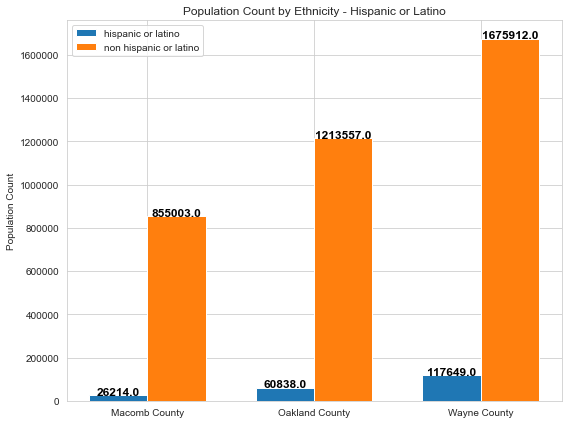

In [265]:
sns.set_style('whitegrid')
x = np.arange(len(ethnic_pop_count_df['NAME'].unique()))
labels = list(ethnic_pop_count_df['NAME'].unique())
width = 0.35
#hisp_latino = ethnic_pop_count_df.loc[ethnic_pop_count_df['variable']=='tot_hisp_latino', 'value']
#not_hisp_latino = ethnic_pop_count_df.loc[ethnic_pop_count_df['variable']=='tot_not_hisp', 'value']



variables = {}
for variable in ethnic_pop_count_df['variable'].unique(): 
    variables[variable] = ethnic_pop_count_df.loc[ethnic_pop_count_df['variable']==variable, 'value']
    variables[variable].apply(lambda x: float(x))



fig, ax = plt.subplots(figsize=(8,6))
hisp = ax.bar(x - width/2, variables['tot_hisp_latino'], width, label='hispanic or latino')
non_hisp = ax.bar(x + width/2, variables['tot_not_hisp'], width, label='non hispanic or latino')


ax.set_ylabel('Population Count')
ax.set_title('Population Count by Ethnicity - Hispanic or Latino')
ax.ticklabel_format(useOffset=False, style='plain')
ax.legend()


#y_offset = -10
for bar in ax.patches:
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
    bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
    bar.get_height(),
    #bar.get_y() + y_offset,
      # This is actual value we'll show.
    bar.get_height(),
      # Center the labels and style them a bit.
    ha='center',
    #va = 'center',
    color='black',
    weight='bold',
    size=12)
# For each patch (basically each rectangle within the bar), add a label.
fig.tight_layout()
plt.xticks(x, labels)
plt.xticks(ha='center')
plt.show()

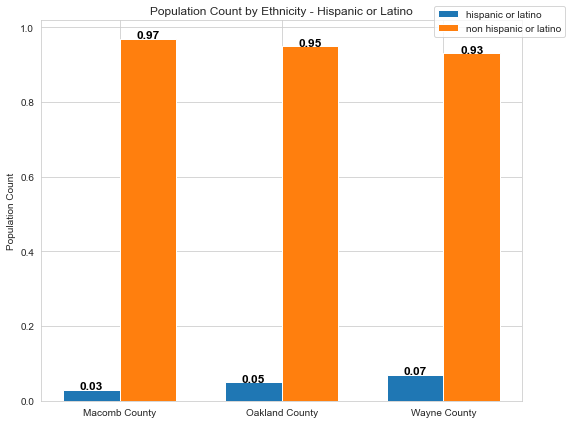

In [270]:
sns.set_style('whitegrid')
x = np.arange(len(ethnic_pop_count_df['NAME'].unique()))
labels = list(ethnic_pop_count_df['NAME'].unique())
width = 0.35
#hisp_latino = ethnic_pop_count_df.loc[ethnic_pop_count_df['variable']=='tot_hisp_latino', 'value']
#not_hisp_latino = ethnic_pop_count_df.loc[ethnic_pop_count_df['variable']=='tot_not_hisp', 'value']



variables = {}
for variable in ethnic_pop_count_df['variable'].unique(): 
    variables[variable] = ethnic_pop_count_df.loc[ethnic_pop_count_df['variable']==variable, 'pct']
    variables[variable].apply(lambda x: float(x))



fig, ax = plt.subplots(figsize=(8,6))
hisp = ax.bar(x - width/2, variables['tot_hisp_latino'], width, label='hispanic or latino')
non_hisp = ax.bar(x + width/2, variables['tot_not_hisp'], width, label='non hispanic or latino')


ax.set_ylabel('Population Count')
ax.set_title('Population Count by Ethnicity - Hispanic or Latino')
ax.ticklabel_format(useOffset=False, style='plain')
ax.legend(bbox_to_anchor=(1.1, 1.05))


#y_offset = -10
for bar in ax.patches:
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
    bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
    bar.get_height(),
    #bar.get_y() + y_offset,
      # This is actual value we'll show.
    bar.get_height(),
      # Center the labels and style them a bit.
    ha='center',
    #va = 'center',
    color='black',
    weight='bold',
    size=12)
# For each patch (basically each rectangle within the bar), add a label.
fig.tight_layout()
plt.xticks(x, labels)
plt.xticks(ha='center')
plt.show()